In [ ]:
# Install dependencies

!git clone https://github.com/bigscience-workshop/promptsource && cd promptsource && sed -i "s/python_requires='>=3.7,<3.10',/python_requires='>=3.7',/" setup.py && pip install .
!pip install --upgrade transformers
!pip install sentencepiece

Cloning into 'promptsource'...
remote: Enumerating objects: 8156, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 8156 (delta 45), reused 59 (delta 20), pack-reused 8050
Receiving objects: 100% (8156/8156), 5.98 MiB | 18.07 MiB/s, done.
Resolving deltas: 100% (3654/3654), done.
Processing /content/promptsource
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
# Define constants

from tqdm.auto import tqdm, trange
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# MODEL = 't5-base'
MODEL = "allenai/unifiedqa-t5-large"
LAYER = 'decoder'

DATASET = 'super_glue'
SUB_DATASET = 'boolq'
EXAMPLES_PER_LABEL = 500
TEST_SPLIT = 0.4
SEED = 1

In [ ]:
# Build dataset

from datasets import interleave_datasets, load_dataset
from promptsource.templates import DatasetTemplates
from transformers import AutoTokenizer, AutoModel

templates = DatasetTemplates(DATASET, SUB_DATASET)
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)


def add_prompts(datapoint: dict) -> dict:
    datapoint['prompts'] = []
    for template in templates.templates.values():
        #prompt is a string with the context and question formatted acording to the template
        #template.apply() takes a dictionary with keys 'question', 'passage', 'idx', 'label', 'prompts'
        prompt = template.apply(datapoint)[0]
        #Tokenizer(text)['input_ids'] returns a list of integers representing the sequence of tokens of the text
        #answers iterate through either False, True or No, Yes depending on the template
        datapoint['prompts'].append(tuple(
            tokenizer(f'{prompt} {answer}')['input_ids']
            for answer in template.get_fixed_answer_choices_list()
        ))
    #returns a dictionary with new key 'prompts'. The value for this key is a list of tuples. Each tuple contains the prompt with a yes and with a no (for each of the templates).
    return datapoint


def reject_prompts_that_are_too_long(datapoint: dict) -> bool:
    max_length = tokenizer.model_max_length
    #the all funciton ands together all the boolean values
    return all(len(prompt) < max_length
               for pair in datapoint['prompts']
               for prompt in pair)


# As per the paper, the dataset is sampled from the validation split
raw_dataset = load_dataset(DATASET, SUB_DATASET, split='validation')
tokenized_dataset = raw_dataset.map(add_prompts, num_proc=4)

# Remove any inputs that are too long
filtered_dataset = tokenized_dataset.filter(reject_prompts_that_are_too_long)


# Create a balanced dataset of size 1000 (500 for each label)
# The datapoints are interleaved so that it's straightforward to create a train-test split later
# TODO probably fine to re-use the seed here for now?
#The list inside the funciton contains two things. The first is a random sample of 500 true statements and the second is a random sample of 500 false statemtns.
#The interleave datasets funciton then alternates one true, one false statement from each of the list values.
#The stange notation is known as method chaining. It exectues filtered_dataset.filter().shuffle().select() and returns the single resulting object.
dataset = interleave_datasets([
    filtered_dataset
        .filter(lambda d: d['label'] == label)
        .shuffle(seed=SEED)
        .select(range(EXAMPLES_PER_LABEL))
    for label in filtered_dataset.unique('label')
])
#NB filtered_dataset.unique('label') returns a list [0,1]
#dataset is a Dataset object

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3245 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3270 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


Filter:   0%|          | 0/3270 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/3254 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3254 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3254 [00:00<?, ? examples/s]

In [ ]:
# Create representations

model = AutoModel.from_pretrained(MODEL).eval().to(DEVICE)
dummy_decoder_input = torch.as_tensor([[0]]).to(DEVICE)


def get_output(input: list[int]) -> torch.Tensor:
    output = model(input_ids=torch.as_tensor([input]).to(DEVICE),
                   decoder_input_ids=dummy_decoder_input, output_hidden_states=True)
    if LAYER == 'encoder':
      return output['encoder_hidden_states'][-1].squeeze()[-1].tolist()
    else:
      return output['decoder_hidden_states'][-1].squeeze().tolist()

#NB: the * operator is known as the unpacking operator and with the square brackets returns a list of an iterable object. It is the same as list(map(...))
with torch.no_grad():
    outputs = [[[*map(get_output, prompts)]
                for prompts in datapoint['prompts']]
               for datapoint in tqdm(dataset)]
representations = torch.tensor(outputs)

#Why is the mean only taken over the index dimension?
# Normalize representations
mean = representations.mean(dim = 0)
stdev = representations.std(dim = 0, correction=0)
normalized_representations = (representations - mean) / stdev


# Create train-test split
test_size = int(len(dataset) * TEST_SPLIT)
test_representations = normalized_representations[:test_size]
test_representation_labels = torch.as_tensor(dataset['label'][:test_size])

train_representations = normalized_representations[test_size:]
train_representation_labels = torch.as_tensor(dataset['label'][test_size:])


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import torch.optim as optim
import torch.nn as nn
import numpy as np
from statistics import mean

def calculate_results(loss_function_name, train_data, test_data, train_data_labels, test_data_labels, num_initialisations=10, num_epochs = 1000, learning_rate = 0.01):
    hyper_parameter=get_hyper_parameter(loss_function_name, train_data, train_data_labels, num_epochs, learning_rate)
    #create the data pd.DataFrame variable
    data = create_data_frame(loss_function_name, hyper_parameter, train_data, test_data, train_data_labels, test_data_labels, num_initialisations, num_epochs, learning_rate)
    return (hyper_parameter, data)

def create_data_frame(loss_function_name, hyper_parameter, train_data, test_data, train_data_labels, test_data_labels, num_initialisations, num_epochs, learning_rate):
  number_of_ccs_probes = 20
  dimension_of_activation_space = train_data.size()[-1]
  if loss_function_name != 'Random':
    loss_function = get_loss_function(loss_function_name)
    loss_function = evaluate_first_variable(train_data, loss_function)
    if hyper_parameter!= None:
      loss_function = evaluate_first_variable(hyper_parameter, loss_function)
    elif loss_function_name == 'Supervised':
      loss_function = evaluate_first_variable(train_data_labels, loss_function)
  all_weights = []
  all_losses = []
  all_test_accuracies = []
  all_train_accuracies = []
  all_cosine_similarities = []

  ccs_loss_function = get_loss_function('CCS')
  ccs_loss_function = evaluate_first_variable(train_data, ccs_loss_function)
  ccs_directions = get_multiple_ccs_directions_and_losses(ccs_loss_function, number_of_ccs_probes, dimension_of_activation_space, num_epochs, learning_rate)[0]
  ccs_directions = torch.stack(ccs_directions)
  #Normalise the ccs weights
  ccs_directions /= ccs_directions.norm(dim = 1, keepdim=True)

  if loss_function_name == 'Random':
    random_directions = get_random_direction(dimension_of_activation_space, num_initialisations)
    for initialisation in trange(num_initialisations):
      weights = random_directions[initialisation]
      test_accuracy = get_accuracy(weights, test_data, test_data_labels)
      train_accuracy = get_accuracy(weights, train_data, train_data_labels)
      cosine_similarity = torch.mean(torch.abs(torch.matmul(ccs_directions, weights/torch.norm(weights))))
      all_weights.append(weights)
      all_losses.append(None)
      all_test_accuracies.append(test_accuracy)
      all_train_accuracies.append(train_accuracy)
      all_cosine_similarities.append(cosine_similarity.item())
    data_frame = pd.DataFrame({'weights': all_weights, 'loss': all_losses, 'train accuracy': all_train_accuracies, 'test accuracy': all_test_accuracies, 'cosine similarity': all_cosine_similarities})
    return data_frame

  for initialisation in trange(num_initialisations):
    get_model
    model_instance = get_model(loss_function_name, dimension_of_activation_space)
    model_instance, loss = train(model_instance, loss_function, num_epochs, learning_rate)
    if loss_function_name in ('MD-CCS', 'MD-Acc', 'MA', 'SMR', 'PCA'):
      model_instance.normalize()
    weights = model_instance.weights.detach()
    weights /= torch.norm(weights)
    test_accuracy = get_accuracy(weights, test_data, test_data_labels)
    train_accuracy = get_accuracy(weights, train_data, train_data_labels)
    cosine_similarity = torch.mean(torch.abs(torch.matmul(ccs_directions, weights)))
    all_weights.append(weights)
    all_losses.append(loss.detach().item())
    all_test_accuracies.append(test_accuracy)
    all_train_accuracies.append(train_accuracy)
    all_cosine_similarities.append(cosine_similarity.item())

  data_frame = pd.DataFrame({'weights': all_weights, 'loss': all_losses, 'train accuracy': all_train_accuracies, 'test accuracy': all_test_accuracies, 'cosine similarity': all_cosine_similarities})
  return data_frame

def get_model(loss_function_name, dimension_of_activation_space):
  if loss_function_name in ('CCS', 'Supervised'):
    model_instance = new_probe(dimension_of_activation_space)
  else:
    model_instance = new_model(dimension_of_activation_space)
    model_instance.normalize()
  return model_instance

def get_hyper_parameter(loss_function_name, data, data_labels, num_epochs, learning_rate):
    if loss_function_name in ('Random', 'Supervised', 'PCA', 'CCS') :
        return None

    number_of_points = 11
    number_of_iterations = 2
    dimension_of_activation_space = data.size()[-1]

    loss_function = get_loss_function(loss_function_name)
    loss_function = evaluate_first_variable(data, loss_function)
    if loss_function_name == 'MD-CCS':
        (initial_interval_lower_value, initial_interval_upper_value) = (0.9,0.999)
        ccs_loss_function = get_loss_function('CCS')
        ccs_loss_function = evaluate_first_variable(data, ccs_loss_function)
        hyper_parameter = get_hyper_parameter_for_ccs(loss_function, ccs_loss_function, number_of_points, number_of_iterations, dimension_of_activation_space, initial_interval_lower_value, initial_interval_upper_value, num_epochs, learning_rate)
    else:
        (initial_interval_lower_value, initial_interval_upper_value) = (0,0.99)
        hyper_parameter = get_hyper_parameter_for_accuracy(loss_function, data, data_labels, number_of_points, number_of_iterations, dimension_of_activation_space, initial_interval_lower_value, initial_interval_upper_value, num_epochs, learning_rate)
    return hyper_parameter

def evaluate_first_variable(first_variable, input_function):
  def output_function(*args, **kwargs):
    output = input_function(first_variable, *args, **kwargs)
    return output
  return output_function

def get_loss_function(loss_function_name):

    def ccs_loss(data, model):
        probabilities = model(data).squeeze()
        consistency_loss = (probabilities.sum(dim=2) - 1) ** 2
        confidence_loss = probabilities.min(dim=2).values ** 2
        loss = torch.mean(consistency_loss + confidence_loss)
        return loss

    def supervised_loss(data, data_labels, model):
        probabilities = model(data)
        #repeat across the prompt style and answer
        data_labels=data_labels.unsqueeze(-1)
        data_labels=data_labels.unsqueeze(-1)
        data_labels = data_labels.expand_as(probabilities).clone()
        #enforce negation consistency
        data_labels[:,:,1] = 1-data_labels[:,:,1]
        loss = torch.mean(torch.square(probabilities - data_labels))
        return loss

    def pca_loss(data, model):
        displacement_data = data[:,:,1,:]-data[:,:,0,:]
        displacement = torch.mean(torch.square(torch.matmul(displacement_data, model.weights/torch.norm(model.weights))))
        return displacement

    def ma_loss(data, hyper_parameter, model):
        displacement_data = data[:,:,1,:]-data[:,:,0,:]
        mean = torch.mean(torch.abs(torch.matmul(displacement_data, model.weights/torch.norm(model.weights))))
        standard_deviation = torch.sqrt(torch.mean(torch.square(torch.abs(torch.matmul(displacement_data, model.weights/torch.norm(model.weights))) - mean)))
        loss = hyper_parameter * standard_deviation - (1-hyper_parameter) * mean
        return loss

    def smr_loss(data, hyper_parameter, model):
        displacement_data = data[:,:,1,:]-data[:,:,0,:]
        mean = torch.mean(torch.abs(torch.matmul(displacement_data, model.weights/torch.norm(model.weights))))
        square_mean_root = torch.square(torch.mean(torch.sqrt(torch.abs(torch.matmul(displacement_data, model.weights/torch.norm(model.weights))))))
        standard_deviation = torch.sqrt(torch.mean(torch.square(torch.abs(torch.matmul(displacement_data, model.weights/torch.norm(model.weights))) - mean)))
        loss = hyper_parameter * standard_deviation - (1-hyper_parameter) * square_mean_root
        return loss

    def md_loss(data, hyper_parameter, model):
        averaged_data = torch.mean(data, dim=2)
        displacement_data = data[:,:,1,:]-data[:,:,0,:]
        mean = torch.mean(torch.square(torch.matmul(averaged_data, model.weights/torch.norm(model.weights))))
        displacement = torch.mean(torch.square(torch.matmul(displacement_data, model.weights/torch.norm(model.weights))))
        loss = hyper_parameter * mean - (1-hyper_parameter) * displacement
        return loss

    if loss_function_name=="Supervised":
        return supervised_loss
    elif loss_function_name=="PCA":
        return pca_loss
    elif loss_function_name=="CCS":
        return ccs_loss
    elif loss_function_name in ("MD-CCS", "MD-Acc"):
        return md_loss
    elif loss_function_name=="SMR":
        return smr_loss
    elif loss_function_name=="MA":
        return ma_loss
    else:
        raise Exception(f'The loss function \'{loss_function_name}\' does not exist.')


class new_probe(nn.Module):
    def __init__(self, number_of_dimensions):
        super(new_probe, self).__init__()
        self.linear = nn.Linear(number_of_dimensions, 1)
        self.sigmoid = nn.Sigmoid()
        self.weights = None
        self.bias = None

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        # Update weights and bias attributes
        self.weights = self.linear.weight.data.clone().squeeze()
        self.bias = self.linear.bias.data.clone().squeeze()
        return x.squeeze()


class new_model(nn.Module):
    def __init__(self, number_of_dimensions):
        super(new_model, self).__init__()
        self.weights = nn.Parameter(torch.normal(0,1,size=[number_of_dimensions]))  # Initialize weights randomly

    #forward pass not needed so set it to the identity map
    def forward(self, x):
        return x

    def normalize(self):
        self.weights.data = self.weights.div(torch.norm(self.weights))

def train(model, loss_function, epochs, learning_rate):
    seed=np.random.randint(100)
    torch.manual_seed(seed)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
      optimizer.zero_grad()
      loss = loss_function(model)
      loss.backward()
      optimizer.step()
    return (model, loss)

def get_random_direction(number_of_dimensions: int, number_of_directions):
  all_directions = []
  for vector in range(number_of_directions):
    direction = torch.normal(0,1,size=[number_of_dimensions])
    direction /= torch.norm(direction)
    all_directions.append(direction)
  return all_directions

def get_multiple_ccs_directions_and_losses(ccs_loss_function, num_initialisations, dimension_of_activation_space, epochs, learning_rate):
  all_weights = []
  all_losses = []
  for initialisation in range(num_initialisations):
    seed=np.random.randint(100)
    torch.manual_seed(seed)
    probe = new_probe(dimension_of_activation_space)
    (probe, loss) = train(probe, ccs_loss_function, epochs, learning_rate)
    weights=probe.weights.detach().squeeze()
    weights /= torch.norm(weights)
    all_weights.append(weights)
    all_losses.append(loss.detach().item())
  return all_weights, all_losses

def get_hyper_parameter_for_ccs(loss_function, ccs_loss_function, number_of_points, number_of_iterations, dimension_of_activation_space, initial_interval_lower_value, initial_interval_upper_value, num_epochs, learning_rate):
  number_of_initialisations = 3
  #This assumes the loss function with the hyper parameter is for a model of class type new_model
  model_instance = new_model(dimension_of_activation_space)
  model_instance.normalize()
  current_interval_lower_value = initial_interval_lower_value
  current_interval_upper_value = initial_interval_upper_value
  best_ccs_cosine_similarity = 0
  best_hyper_parameter = initial_interval_lower_value
  number_of_ccs_probes = 20

  ccs_directions = get_multiple_ccs_directions_and_losses(ccs_loss_function, number_of_ccs_probes, dimension_of_activation_space, num_epochs, learning_rate)[0]
  ccs_directions = torch.stack(ccs_directions)
  #Normalise the ccs weights
  ccs_directions /= ccs_directions.norm(dim = 1, keepdim=True)

  optimizer = optim.AdamW(model_instance.parameters(), lr=learning_rate)

  for iteration in trange(number_of_iterations):
    interval_width = current_interval_upper_value - current_interval_lower_value
    for point in trange(number_of_points):
      current_hyper_parameter = current_interval_lower_value + point * (interval_width / (number_of_points - 1))
      current_loss_function = evaluate_first_variable(current_hyper_parameter,loss_function)
      all_current_cosine_similarities = []
      for initialisation in range(number_of_initialisations):
        model_instance = train(model_instance, current_loss_function, num_epochs, learning_rate)[0]
        model_instance.normalize()
        current_ccs_cosine_similarity = torch.mean(torch.abs(torch.matmul(ccs_directions, model_instance.weights.detach())))
        all_current_cosine_similarities.append(current_ccs_cosine_similarity.item())
      average_current_cosine_similarity = mean(all_current_cosine_similarities)
      if best_ccs_cosine_similarity < average_current_cosine_similarity:
        best_ccs_cosine_similarity = average_current_cosine_similarity
        best_hyper_parameter = current_hyper_parameter
    interval_lower_value = max(current_interval_lower_value, best_hyper_parameter - interval_width/(number_of_points - 1))
    interval_upper_value = min(current_interval_upper_value, best_hyper_parameter + interval_width/(number_of_points - 1))
    current_interval_lower_value = interval_lower_value
    current_interval_upper_value = interval_upper_value
  return best_hyper_parameter

def get_hyper_parameter_for_accuracy(loss_function, data, data_labels, number_of_points, number_of_iterations, dimension_of_activation_space, initial_interval_lower_value, initial_interval_upper_value, num_epochs, learning_rate):
  number_of_initialisations = 3
  model_instance = new_model(dimension_of_activation_space)
  model_instance.normalize()
  current_interval_lower_value = initial_interval_lower_value
  current_interval_upper_value = initial_interval_upper_value
  best_accuracy = 0
  best_hyper_parameter = initial_interval_lower_value

  optimizer = optim.AdamW(model_instance.parameters(), lr=learning_rate)

  for iteration in trange(number_of_iterations):
    interval_width = current_interval_upper_value - current_interval_lower_value
    for point in trange(number_of_points):
      current_hyper_parameter = current_interval_lower_value + point * (interval_width / (number_of_points - 1))
      current_loss_function = evaluate_first_variable(current_hyper_parameter,loss_function)
      all_current_accuracies = []
      for initialisation in range(number_of_initialisations):
        model_instance = train(model_instance, current_loss_function, num_epochs, learning_rate)[0]
        model_instance.normalize()
        current_accuracy = get_accuracy(model_instance.weights.detach(), data, data_labels)
        all_current_accuracies.append(current_accuracy)
      average_current_accuracy = mean(all_current_accuracies)
      if best_accuracy < average_current_accuracy:
        best_accuracy = average_current_accuracy
        best_hyper_parameter = current_hyper_parameter

    interval_lower_value = max(current_interval_lower_value, best_hyper_parameter - interval_width/(number_of_points - 1))
    interval_upper_value = min(current_interval_upper_value, best_hyper_parameter + interval_width/(number_of_points - 1))
    current_interval_lower_value = interval_lower_value
    current_interval_upper_value = interval_upper_value
  return best_hyper_parameter


def get_accuracy(direction, data, data_labels):
  direction /= torch.norm(direction)

  displaced_data = data[:,:,1,:] - data[:,:,0,:]

  #calculate accuracy
  truth_components=torch.matmul(displaced_data, direction).squeeze()
  truth_components[truth_components>0]=1
  truth_components[truth_components<0]=0
  data_labels = data_labels.unsqueeze(1).repeat(1,truth_components.size()[-1])
  accuracy=torch.max(torch.sum(truth_components==data_labels),torch.sum((1-truth_components)==data_labels))/truth_components.numel()
  return accuracy.item()

#create an imutable data class
class experimental_data():
  def __init__(self, dataset: str, sub_dataset: str, model: str, layer: str, loss_function_name: str, hyper_parameter: float, data: pd.DataFrame):
      self.dataset = dataset
      self.sub_dataset = sub_dataset
      self.model = model
      self.layer = layer
      self.loss_function_name = loss_function_name
      self.hyper_parameter = hyper_parameter
      self.data = data

In [15]:
all_loss_functions=['Random', 'Supervised', 'PCA', 'CCS', 'MD-CCS', 'MD-Acc', 'SMR', 'MA']
experimental_data_for_all_functions = {}
for loss_function_name in all_loss_functions:
    (hyper_parameter, data) = calculate_results(loss_function_name, train_representations, test_representations, train_representation_labels, test_representation_labels)
    experimental_data_for_all_functions[loss_function_name]=experimental_data(DATASET, SUB_DATASET,MODEL, LAYER, loss_function_name, hyper_parameter, data)

In [19]:
########################
#Print the data
########################
print("SUMMARY DATA FOR INITIALISATIONS THAT MINIMISE LOSS")
for loss_function_name in all_loss_functions:
    print()
    print()
    print()
    print(f'************************ {loss_function_name} ************************')
    data_frame = experimental_data_for_all_functions[loss_function_name].data
    hyper_parameter = experimental_data_for_all_functions[loss_function_name].hyper_parameter
    print(f'Hyper parameter: {hyper_parameter}')
    print(data_frame[data_frame.loss == data_frame.loss.min()][['loss', 'train accuracy', 'test accuracy', 'cosine similarity']])

print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print("SUMMARY OF ALL DATA")
for loss_function_name in all_loss_functions:
    print()
    print()
    print()
    print(f'************************ {loss_function_name} ************************')
    data_frame = experimental_data_for_all_functions[loss_function_name].data
    hyper_parameter = experimental_data_for_all_functions[loss_function_name].hyper_parameter
    print(f'Hyper parameter: {hyper_parameter}')
    print(data_frame[['loss', 'train accuracy', 'test accuracy', 'cosine similarity']])

SUMMARY DATA FOR INITIALISATIONS THAT MINIMISE LOSS



************************ Random ************************
Hyper parameter: None
Empty DataFrame
Columns: [loss, train accuracy, test accuracy, cosine similarity]
Index: []



************************ Supervised ************************
Hyper parameter: None
       loss  train accuracy  test accuracy  cosine similarity
9  0.151127        0.847833        0.83625           0.721432



************************ PCA ************************
Hyper parameter: None
       loss  train accuracy  test accuracy  cosine similarity
3  0.003055        0.507167        0.51175           0.026953



************************ CCS ************************
Hyper parameter: None
       loss  train accuracy  test accuracy  cosine similarity
4  0.147316        0.810333         0.8275           0.993703
8  0.147316        0.810333         0.8275           0.993703











SUMMARY OF ALL DATA



************************ Random ************************
Hyper

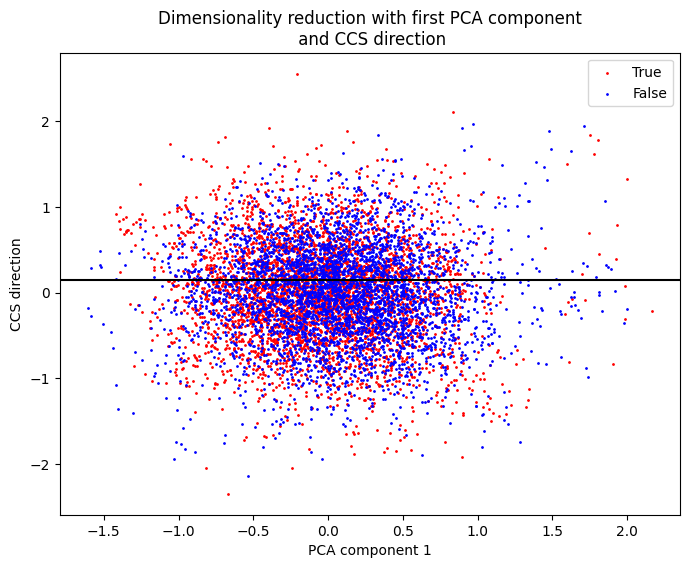

In [12]:
import matplotlib.pyplot as plt

#Plot the figure of CCS direction, PCA direction and decision boundary.
#Use CCS lowest loss and PCA lowest loss
#Orthogonalise the PCA vector
#projected data > - bias / weightnorm

def plot_data_distribution(train_data, test_data, test_labels, num_epochs = 1000, learning_rate = 0.01):
  dimension_of_activation_space = train_data.size()[-1]
  test_labels = test_labels.unsqueeze(-1)
  test_labels = test_labels.expand_as(test_data[:,:,0,0]).bool()

  ccs_loss_function = get_loss_function('CCS')
  ccs_loss_function = evaluate_first_variable(train_data, ccs_loss_function)
  ccs_probe = new_probe(dimension_of_activation_space)
  ccs_probe = train(ccs_probe, ccs_loss_function, num_epochs, learning_rate)[0]
  ccs_weights = ccs_probe.weights.detach()
  ccs_bias = ccs_probe.bias.detach()/torch.norm(ccs_weights)
  ccs_weights/=torch.norm(ccs_weights)

  y_data = torch.matmul(test_data, ccs_weights)
  yes_true_y_data = y_data[:,:,1][test_labels]
  yes_false_y_data = y_data[:,:,1][~test_labels]
  no_true_y_data = y_data[:,:,0][test_labels]
  no_false_y_data = y_data[:,:,0][~test_labels]
  true_y_data = torch.flatten(torch.cat([yes_true_y_data, no_true_y_data], dim=0))
  false_y_data = torch.flatten(torch.cat([yes_false_y_data, no_false_y_data], dim=0))

  pca_loss_function = get_loss_function('PCA')
  pca_loss_function = evaluate_first_variable(train_data, pca_loss_function)
  pca_model = new_model(dimension_of_activation_space)
  pca_model = train(pca_model, pca_loss_function, num_epochs, learning_rate)[0]
  pca_weights = pca_model.weights.detach()
  #Orthogonalise the pca direction with the ccs direction
  pca_weights -= torch.dot(pca_weights, ccs_weights) * ccs_weights
  pca_weights/=torch.norm(pca_weights)

  x_data = torch.matmul(test_data, pca_weights)
  yes_true_x_data = x_data[:,:,1][test_labels]
  yes_false_x_data = x_data[:,:,1][~test_labels]
  no_true_x_data = x_data[:,:,0][test_labels]
  no_false_x_data = x_data[:,:,0][~test_labels]
  true_x_data = torch.flatten(torch.cat([yes_true_x_data, no_true_x_data], dim=0))
  false_x_data = torch.flatten(torch.cat([yes_false_x_data, no_false_x_data], dim=0))

  plt.figure(figsize=(8, 6))
  plt.scatter(true_x_data, true_y_data, s=1, color='red', label='True')
  plt.scatter(false_x_data, false_y_data, s=1, color='blue', label='False')
  plt.axhline(y = - ccs_bias, color = 'black', linestyle = '-')
  plt.xlabel('PCA component 1')
  plt.ylabel('CCS direction')
  plt.title("Dimensionality reduction with first PCA component\n and CCS direction")
  plt.legend()
  plt.show()


plot_data_distribution(train_representations, test_representations, test_representation_labels)

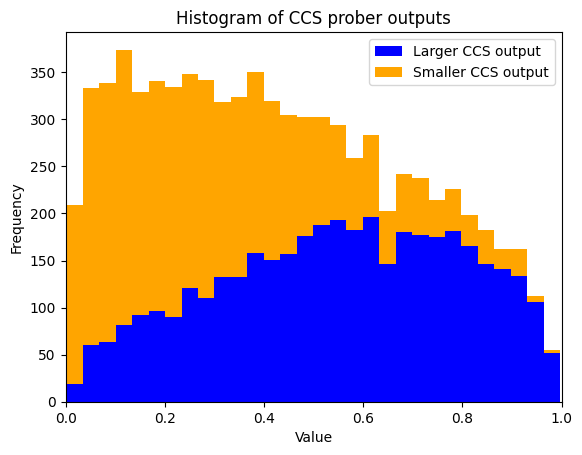

In [9]:
#histogram of ccs outputs

#trains a probe on the test data, and then generates the histogram on the test set
def create_prober_histogram(train_data, test_data, num_epochs = 1000, learning_rate = 0.01):
  dimension_of_activation_space = train_data.size()[-1]
  ccs_loss_function = get_loss_function('CCS')
  ccs_loss_function = evaluate_first_variable(train_data, ccs_loss_function)
  ccs_probe = new_probe(dimension_of_activation_space)
  ccs_probe = train(ccs_probe, ccs_loss_function, num_epochs, learning_rate)[0]

  #calculate difference in prober outputs over test set
  test_probabilities = ccs_probe(test_data)
  yes_probabilities = test_probabilities[:, :, 1]
  no_probabilities = test_probabilities[:, :, 0]

  yes_truth_mask = yes_probabilities > no_probabilities
  no_truth_mask = no_probabilities >= yes_probabilities

  true_probabilities = torch.cat([yes_probabilities[yes_truth_mask], no_probabilities[no_truth_mask]],dim=0)
  false_probabilities = torch.cat([yes_probabilities[no_truth_mask], no_probabilities[yes_truth_mask]],dim=0)


  # Set the number of bins for the histogram
  num_bins = 30

  # Plot the histogram
  plt.hist([true_probabilities.detach().numpy(), false_probabilities.detach().numpy()], bins=num_bins, stacked=True, color=['blue', 'orange'], label=['Larger CCS output', 'Smaller CCS output'])
  plt.title('Histogram of CCS prober outputs')
  plt.xlabel('Value')
  plt.xlim([0,1])
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

create_prober_histogram(train_representations, test_representations)